In [1]:
import ironman
import numpy as np
import pandas as pd
import corner
import matplotlib.pyplot as plt
import rmfit
from astropy import units as u
from astropy import constants as c
import juliet
from astropy.timeseries import LombScargle

In [2]:
# from matplotlib import rc
# rc('font', **{'family':'sans-serif'}) #Use only if you have pdflatex (recommended)
# rc('text', usetex=True)

# plt.rcParams['xtick.top'] =  True
# plt.rcParams['xtick.direction'] =  'in'
# plt.rcParams['xtick.major.width'] =  1.0
# plt.rcParams['xtick.minor.width'] =  1.0
# plt.rcParams['ytick.right'] =  True
# plt.rcParams['ytick.direction'] =  'in'
# plt.rcParams['ytick.major.width'] = 1.0
# plt.rcParams['ytick.minor.width'] =  1.0
# plt.rcParams['lines.markeredgewidth'] =  1.0

In [3]:
# from matplotlib import rc
# rc('font', **{'family':'sans-serif'}) #Use only if you have pdflatex (recommended)
# rc('text', usetex=True)

plt.rcParams['xtick.top'] =  True
plt.rcParams['xtick.direction'] =  'in'
plt.rcParams['xtick.major.width'] =  1.0
plt.rcParams['xtick.minor.width'] =  1.0
plt.rcParams['ytick.right'] =  True
plt.rcParams['ytick.direction'] =  'in'
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['ytick.minor.width'] =  1.0
plt.rcParams['lines.markeredgewidth'] =  1.0

In [4]:
dataset = juliet.load(input_folder = 'TOI-2431_juliet_GP_NEW', out_folder = 'TOI-2431_juliet_GP_NEW')
results = dataset.fit(sampler = "dynamic_dynesty")

Detected dynamic_dynesty sampler output files --- extracting from TOI-2431_juliet_GP_NEW/_dynesty_DNS_posteriors.pkl


In [5]:
#results.nested_sampling.results.logz[-1]

In [6]:
P = juliet.utils.get_quantiles(results.posteriors['posterior_samples']['P_p1'])[0]
t0 = juliet.utils.get_quantiles(results.posteriors['posterior_samples']['t0_p1'])[0]
print(P,t0)

0.22419577294030876 2460258.868549302


# Photometry

# Radial Velocities

In [7]:
dataset.times_rv

{'NEID': array([2460661.69434182, 2460661.83431809, 2460663.81846735,
        2460664.63461503, 2460665.58387257, 2460680.64477062,
        2460680.74655183, 2460685.70225794, 2460725.61728925,
        2460725.62103128, 2460725.67232209, 2460725.6758779 ]),
 'HPF': array([2460673.70990708, 2460712.60662992, 2460715.59766566])}

In [8]:
dataset.data_rv

{'NEID': array([ -8.98063907, -21.92102423,  -1.93804619,   6.41213063,
          9.8441314 , -12.13004336,   6.77473854,   4.61035712,
         -1.36241563,  -6.29403621, -16.34462272, -11.34680843]),
 'HPF': array([-25.17060598,  13.29367368,   5.9441003 ])}

In [9]:
#Define time range for model evaluation

min_time, max_time = np.min(dataset.times_rv["NEID"]) - 10, np.max(dataset.times_rv["NEID"]) + 10
model_times = np.linspace(min_time, max_time, 10000)
full_model, components = results.rv.evaluate("NEID", t = model_times, GPregressors = model_times, return_components = True)

Detected dynamic_dynesty sampler output files --- extracting from TOI-2431_juliet_GP_NEW/_dynesty_DNS_posteriors.pkl
Detected dynamic_dynesty sampler output files --- extracting from TOI-2431_juliet_GP_NEW/_dynesty_DNS_posteriors.pkl


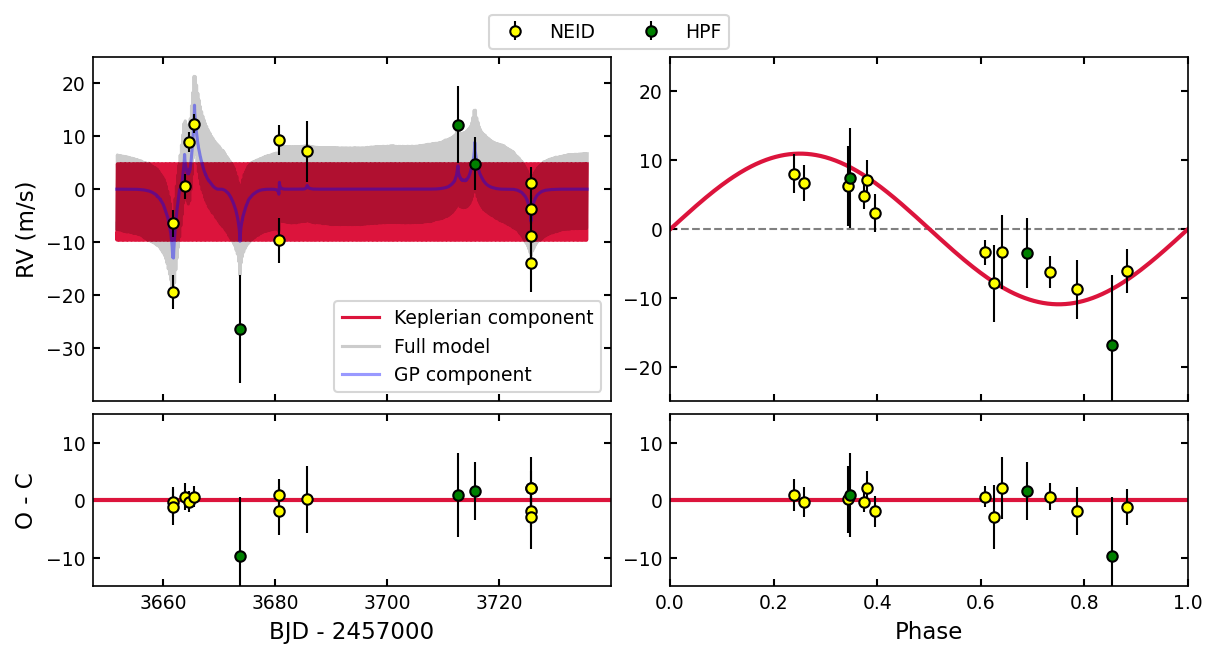

In [10]:
fig = plt.figure(figsize=(8,4),dpi=150,constrained_layout=True)

gs = fig.add_gridspec(3, 12)
ax1 = fig.add_subplot(gs[:2, :6])
ax2 = fig.add_subplot(gs[2, :6], sharex = ax1)
ax3 = fig.add_subplot(gs[:2, 6:], )
ax4 = fig.add_subplot(gs[2, 6:], sharex = ax3)
#ax3 = fig.add_subplot(gs[:2, 1])

instruments = ["NEID", "HPF"]
colors = ["yellow", "green"]

####################################################### For Data Plotting #######################################################

for instrument, color in zip(instruments,colors):
    jitter = juliet.utils.get_quantiles(results.posteriors['posterior_samples']['sigma_w_'+instrument])[0]
    ax1.errorbar(dataset.times_rv[instrument]-2457000,dataset.data_rv[instrument] - components['mu'][instrument], \
                 yerr = dataset.errors_rv[instrument], fmt = 'o',mec='black', mfc = color, ecolor = "black", \
                 elinewidth=1, zorder = 100)

###################################################### For Model Plotting ######################################################
ax1.plot(model_times-2457000,results.rv.model['deterministic'],label = 'Keplerian component', color = 'crimson')
ax1.plot(model_times-2457000,full_model - components['mu']["NEID"],label='Full model',alpha = 0.2,color='black')
ax1.plot(model_times-2457000,results.rv.model['GP'], label = 'GP component', alpha = 0.4, color='blue')
phase  = ((model_times-t0 + 0.5*P) % P)/P
idx = np.argsort(phase)
ax3.plot(phase[idx],results.rv.model["p1"][idx],lw = 2, color = "crimson")

ax2.set_xlabel("BJD - 2457000", fontsize=11)
ax1.set_ylabel("RV (m/s)", fontsize=11)
ax2.set_ylabel("O - C", fontsize=11)
plt.setp(ax1.get_xticklabels(), visible=False)
ax2.set_ylim(-15,15)
ax1.set_ylim(-40,25)
ax1.set_yticks([-30,-20,-10,0,10,20])
ax2.set_yticks([-10,0,10])

################################################### To model the phased RVs and the residuals #################################

for instrument, color in zip(instruments,colors):
    dataset = juliet.load(input_folder = 'TOI-2431_juliet_GP_NEW', out_folder = 'TOI-2431_juliet_GP_NEW')
    results = dataset.fit(sampler = "dynamic_dynesty")
    times = dataset.times_rv[instrument]
    full_model, components = results.rv.evaluate(instrument, t = times, GPregressors = times, return_components = True)
    gp = results.rv.model["GP"]
    phase  = ((times-t0 + 0.5*P) % P)/P
    ax2.errorbar(dataset.times_rv[instrument]-2457000,dataset.data_rv[instrument] - full_model, \
                 yerr = dataset.errors_rv[instrument], fmt = 'o',mec='black', mfc = color, ecolor = "black", \
                 elinewidth=1, zorder = 100)
    ax4.errorbar(phase,dataset.data_rv[instrument] - full_model, \
                 yerr = dataset.errors_rv[instrument], fmt = 'o',mec='black', mfc = color, ecolor = "black", \
                 elinewidth=1, zorder = 100)
    ax3.errorbar(phase,dataset.data_rv[instrument] - gp - components['mu'][instrument], \
                 yerr = dataset.errors_rv[instrument], fmt = 'o',mec='black', mfc = color, ecolor = "black", \
                 elinewidth=1, zorder = 100, label = instrument)

ax4.set_xlabel("Phase", fontsize=11)
plt.setp(ax3.get_xticklabels(), visible=False)
ax4.set_ylim(-15,15)
ax4.set_yticks([-10,0,10])
ax3.set_ylim(-25,25)
ax3.set_xlim(0,1)

ax2.axhline(0, color = "crimson", lw = 2)
ax4.axhline(0, color = "crimson", lw = 2)
ax3.axhline(0.0, lw=1, ls = "--", color = "grey", zorder = -1000)

fig.set_facecolor('w')
ax1.legend()
handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.075), ncol=3)
plt.savefig("toi_2431_GP_fit.png", bbox_inches="tight", dpi=600)
plt.show()

In [13]:
def get_vals(vec):
    fvec   = np.sort(vec)

    fval  = np.median(fvec)
    nn = int(np.around(len(fvec)*0.15865))

    vali,valf = fval - fvec[nn],fvec[-nn] - fval
    return fval,vali,valf
    
def print_mass_radius_rho_sma_planet(rstar=1.0, rstar_err=0.1, mstar=1.0, mstar_err=0.1, r_units=u.Rjup, sma_units=u.AU, m_units=u.Mjup):
    """
    Calculate and print the planet's mass, radius, density, and semi-major axis. If r_star and/or m_star are not sampled they must be added as inputs

    Parameters:
    rstar (float) optional: Mean stellar radius in solar radii. Only if r_star not sampled
    rstar_err (float) optional: Error in stellar radius. Only if r_star not sampled
    mstar (float) optional: Mean stellar mass in solar masses. Only if m_star not sampled
    mstar_err (float) optional: Error in stellar mass. Only if m_star not sampled
    r_units (Astropy Unit): Desired output units for the planet's radius.
    sma_units (Astropy Unit): Desired output units for the semi-major axis.
    m_units (Astropy Unit): Desired output units for the planet's mass.
    """
    # chain = self.fit.chain
    Rs = np.random.normal(rstar, rstar_err, len(results.posteriors['posterior_samples']['K_p1'])) * u.Rsun
    Ms = np.random.normal(mstar, mstar_err, len(results.posteriors['posterior_samples']['K_p1'])) * u.Msun

    rp = results.posteriors['posterior_samples']['p_p1'] * Rs
    rp = rp.to(r_units)
    r_planet_val, r_planet_down, r_planet_up = get_vals(rp.value)
    print(f"R_planet: {r_planet_val:.4f} +{r_planet_up:.4f} -{r_planet_down:.4f} {r_units}")

    transit_depth = (rp / Rs.to(r_units))**2
    transit_depth_val, transit_depth_down, transit_depth_up = get_vals(transit_depth.value)
    print(f"Transit depth: {transit_depth_val:.6f} +{transit_depth_up:.6f} -{transit_depth_down:.6f}")
    
    P_sec = results.posteriors['posterior_samples']['P_p1'] * u.day
    P_sec = P_sec.to(u.s)
    aRs = results.posteriors['posterior_samples']['a_p1'] * Rs
    sma = aRs.to(sma_units)
    sma_val, sma_down, sma_up = get_vals(sma.value)
    print(f"Sma_planet: {sma_val:.4f} +{sma_up:.4f} -{sma_down:.4f} {sma_units}")

    K = results.posteriors['posterior_samples']['K_p1'] * u.m / u.s
    e = 0
    cos_inc = (results.posteriors['posterior_samples']['b_p1'] * Rs) / sma
    cos_inc = np.clip(cos_inc, -1, 1)
    inc = np.arccos(cos_inc)
    inc_val, inc_down, inc_up = get_vals(inc.value)
    print(f"Inclination: {np.degrees(inc_val):.4f} +{np.degrees(inc_up):.4f} -{np.degrees(inc_down):.4f} deg")
    #inc = 73.83677068878853 * np.pi / 180.0  # Convert to radians
    mp = K * np.sqrt(Ms * sma * (1 - e**2) / c.G) / np.sin(inc)
    mp = mp.to(m_units)
    m_planet_val, m_planet_down, m_planet_up = get_vals(mp.value)
    print(f"M_planet: {m_planet_val:.4f} +{m_planet_up:.4f} -{m_planet_down:.4f} {m_units}")

    dens = (3 * mp / (4 * np.pi * rp**3)).to(u.g / u.cm**3)
    dens_val, dens_down, dens_up = get_vals(dens.value)
    print(f"Rho_planet: {dens_val:.4f} +{dens_up:.4f} -{dens_down:.4f} g/cm^3")

In [14]:
print_mass_radius_rho_sma_planet(rstar=0.66,rstar_err=0.01,mstar=0.66,mstar_err=0.02,r_units=u.Rearth,m_units=u.Mearth)

R_planet: 1.5416 +0.0596 -0.0462 earthRad
Transit depth: 0.000458 +0.000034 -0.000023
Sma_planet: 0.0063 +0.0004 -0.0006 AU
Inclination: 73.3875 +4.4069 -5.9157 deg
M_planet: 5.1469 +1.6778 -1.5313 earthMass
Rho_planet: 7.6201 +2.6817 -2.3588 g/cm^3
